![Banner logo](../fig/citrine_banner.png)

# Citrination t-SNE API

*Authors: Erin Antono, Enze Chen*

In this tutorial, we're going to learn to use Citrination to generate a useful data analysis called t-SNE. This data visualization technique enables you to represent a high dimensional set of data in fewer dimensions in a way that preserves the local structure of the data. In materials informatics, this allows you to create a two-dimensional plot of a set of materials where points corresponding to similar materials are grouped together in two-dimensional space. More information on t-SNE here: https://lvdmaaten.github.io/tsne/

This tutorial will teach you to create and export a two-dimensional t-SNE plot for any data on Citrination. The first step is to create a [data view on Citrination](https://citrination.com/data_views). We have instructions for doing so through the [UI](../citrination_ui_examples/03_data_views.md) and [API](clients_sequence/2_data_views_client_api_tutorial.ipynb).

We'll be using [this data view](https://citrination.com/data_views/4106) (view id `4106`) for this tutorial, which includes a model predicting experimental band gaps based on data compiled by W.H. Strehlow and E.L. Cook, which can be viewed in [this dataset](https://citrination.com/datasets/1160/show_search).

## Python package imports

In [15]:
# Standard packages
import os

# Third-party packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from citrination_client import CitrinationClient

## Get the t-SNE projections

In [2]:
# Initialize the CitrinationClient
site = "https://citrination.com" # public
client = CitrinationClient(api_key=os.environ["CITRINATION_API_KEY"], site=site)

tsne_dataviewid = "4106"
tsne = client.models.tsne(tsne_dataviewid)
print(tsne.projections())

dict_keys(['Property Color', 'Property Band gap'])


The `tsne` call returns a dictionary where the top level keys correspond to the properties that are being modeled. In this data view, the model inputs are `Chemical formula` and `Crystallinity`. Citrination represents a chemical formula by calculating over 50 material descriptors. The t-SNE plot reduces that into just 2 dimensions. Let's look at the t-SNE plot for `Band gap`.

In [14]:
[x for x in dir(tsne.get_projection("Property Band gap")) if not x.startswith('_')]

['responses', 'tags', 'uids', 'xs', 'ys']

- `x` is the x component of the t-SNE plot
- `y` is the y component of the t-SNE plot
- `z` is the property value (Band gap in this example)
- `uid` is the uid of the record on Citrination. You can find the record by going to https://citrination.com/pif/{uid}
- `label` is the list of the values of the model inputs for the record

## Plot the t-SNE projection

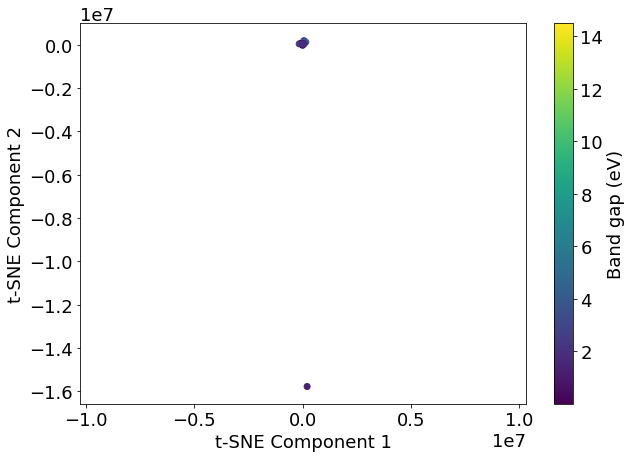

In [21]:
gap_projection = tsne.get_projection("Property Band gap")
plt.rcParams.update({'figure.figsize':(10,7), 'font.size':18})
plt.scatter(gap_projection.xs, gap_projection.ys, c=gap_projection.responses)
plt.colorbar(label="Band gap (eV)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.axes().set_aspect('equal', 'datalim')
plt.show()

When interpreting a t-SNE plot, keep in mind that the t-SNE components plotted on the $x$ and $y$ axes have no physical meaning. Since the t-SNE algorithm preserves the local structure of the data, we look at points that end up close together. Just from looking at the plot, we can see that there are a few clusters of materials; let's take a look at what those materials are.

(Note: t-SNE is a non-deterministic algorithm, so the plot will change if the underlying Data View is retrained)

## Inspect candidates of interest more closely

In [22]:
# Load the coordinates and band gap values into a numpy array
coordinates_and_bg = np.zeros((len(gap_projection.xs), 3))
coordinates_and_bg[:,0] = gap_projection.xs
coordinates_and_bg[:,1] = gap_projection.ys
coordinates_and_bg[:,2] = gap_projection.responses

In [23]:
# Find the n materials closest to the target material, as specified by index
# based on cartesian distance in the t-SNE coordinates
def find_most_similar_materials(index, coordinates, n_materials=10):
    distances = np.linalg.norm(coordinates_and_bg[:,0:2] - coordinates_and_bg[index,0:2], axis=1)
    return np.argsort(distances)[1:n_materials+1]

From inspecting this cluster of materials, we can see that the t-SNE plot has grouped highly ionic materials together, and that these materials have very high band gaps.

Maximum band gap material:
14.5, Be1O1, Band gap: 14.5, URL: https://citrination.com/pif/1160/3/66756141934A40C0096E45068CE9B071
Similar materials:
Red, Single crystalline, 2.3, Re1O3, Band gap: 2.3, URL: https://citrination.com/pif/1160/3/259F6F9E79DF50616E5E4B3FBFF660D8
1.0, Cr2O3, Band gap: 1.0, URL: https://citrination.com/pif/1160/3/EBB6D46F39ACEA3D3B617FB2013FD5A9
0.3, V1O1, Band gap: 0.3, URL: https://citrination.com/pif/1160/3/13A857F2BEA1AF21C9495CA6BFEE37BF
Yellow, Polycrystalline, 0.23, Cr1O2, Band gap: 0.23, URL: https://citrination.com/pif/1160/3/D45EB1BFD5F6EBEBD7E7D8BF3A43862C
Yellow, Single crystalline, 2.6, Mn1O1, Band gap: 2.6, URL: https://citrination.com/pif/1160/3/24D7AFCC520745674C794B501C56F17F
Red, Polycrystalline, 4.6, Ta2O5, Band gap: 4.6, URL: https://citrination.com/pif/1160/3/26A104A7ECF4E7E8B34F7C340EEE1DCA
Yellow, Polycrystalline, 2.34, Fe2O3, Band gap: 2.34, URL: https://citrination.com/pif/1160/3/8133CE095FD3929E58CE750035F7DD79
Blue, Single crystalline

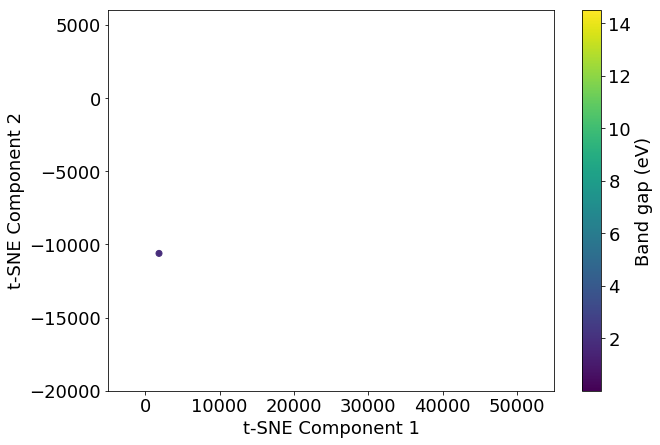

In [24]:
# Get the index of the maximum band gap material
max_bg_index = np.argmax(coordinates_and_bg, axis=0)[2]
print("Maximum band gap material:")
print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
      .format(gap_projection.tags[max_bg_index], 
              gap_projection.responses[max_bg_index],
              gap_projection.uids[max_bg_index])
     )
print("Similar materials:")
for idx in find_most_similar_materials(max_bg_index, coordinates_and_bg[:,0:2]):
    print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
          .format(gap_projection.tags[idx],
                  gap_projection.responses[idx],
                  gap_projection.uids[idx])
         )

plt.figure()
plt.scatter(gap_projection.xs, gap_projection.ys, c=gap_projection.responses)
plt.colorbar(label="Band gap (eV)")
plt.scatter(coordinates_and_bg[max_bg_index, 0], coordinates_and_bg[max_bg_index, 1],
            marker="*", c="r", s=200)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
#plt.axes().set_aspect('equal', 'datalim')
print(min(gap_projection.xs), max(gap_projection.xs), min(gap_projection.ys), max(gap_projection.ys))
plt.xlim(-5000,55000)
plt.ylim(-20000,6000)
plt.show()

Now let's figure out what material the outlier point with the largest y-value corresponds to

Outlier material (point with the highest y-value):
Brown, Polycrystalline, 3.5, Er1B6, Band gap: 3.5, URL: https://citrination.com/pif/1160/3/C5089153E0C149D17149F63755DD5E0E
-159898.72132279156 206896.81792691996 -15782246.818008263 189135.59844524862


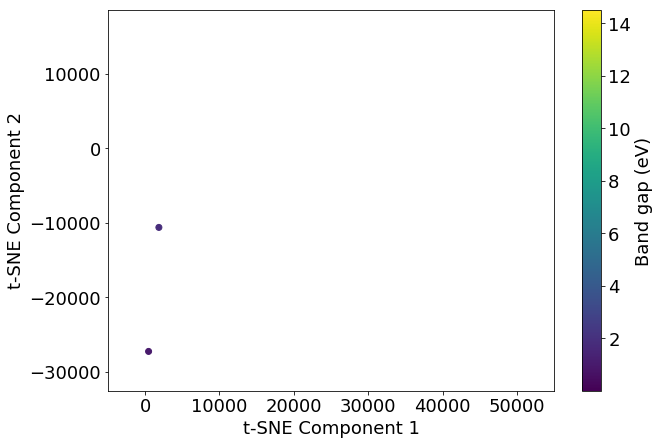

In [25]:
outlier_index = np.argmax(coordinates_and_bg, axis=0)[1]
print("Outlier material (point with the highest y-value):")
print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
      .format(gap_projection.tags[outlier_index],
              gap_projection.responses[outlier_index],
              gap_projection.uids[outlier_index])
     )

plt.figure()
plt.scatter(gap_projection.xs, gap_projection.ys, c=gap_projection.responses)
plt.colorbar(label="Band gap (eV)")
plt.scatter(coordinates_and_bg[outlier_index, 0], coordinates_and_bg[outlier_index, 1],
            marker="*", c="r", s=200)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
print(min(gap_projection.xs), max(gap_projection.xs), min(gap_projection.ys), max(gap_projection.ys))
plt.xlim(-5000,55000)
plt.ylim(-20000,6000)
plt.axes().set_aspect('equal', 'datalim')
plt.show()

We can also find materials that are similar to a given material in the dataset. Let's find materials similar to Cr3Se4 https://citrination.com/datasets/1160/version/3/pif/0478C7E0B7C4F75C6081EC5184522704. The uid comes in the format dataset_id/version/pif_id. For Cr3Se4, the uid is 1160/3/0478C7E0B7C4F75C6081EC5184522704.

0.015, Cr3Se4, Band gap: 0.015, URL: https://citrination.com/pif/1160/3/0478C7E0B7C4F75C6081EC5184522704
Similar materials:
0.025, Cr2Se3, Band gap: 0.025, URL: https://citrination.com/pif/1160/3/FD2CFCBFC7676D6916A975F1FAB8CE4F
Gray, Polycrystalline, 0.34, Fe2Te3, Band gap: 0.34, URL: https://citrination.com/pif/1160/3/3F817B4EEF4F163C474653F3CA707081
Dark Red, Polycrystalline, 1.0, Ru1Se2, Band gap: 1.0, URL: https://citrination.com/pif/1160/3/EB7F89526BB12CD5DB57956267A4B814
Brown-Black, Single crystalline, 1.35, Mn1Te1, Band gap: 1.35, URL: https://citrination.com/pif/1160/3/A41BC39EEF26C13CB1A282FAE4A58B2D
0.7, Rh1Se3, Band gap: 0.7, URL: https://citrination.com/pif/1160/3/30EEC951791B144F58B004220982F02B
Gray, Polycrystalline, 0.46, Fe1Te2, Band gap: 0.46, URL: https://citrination.com/pif/1160/3/D9F7DB460294A43201688A28B60D3B96
0.2, Co1Te1.88, Band gap: 0.2, URL: https://citrination.com/pif/1160/3/2102FB8D9A714520336C7CCDC3766993
Gray, Polycrystalline, 0.17, Fe1Sb2, Band gap: 0.1

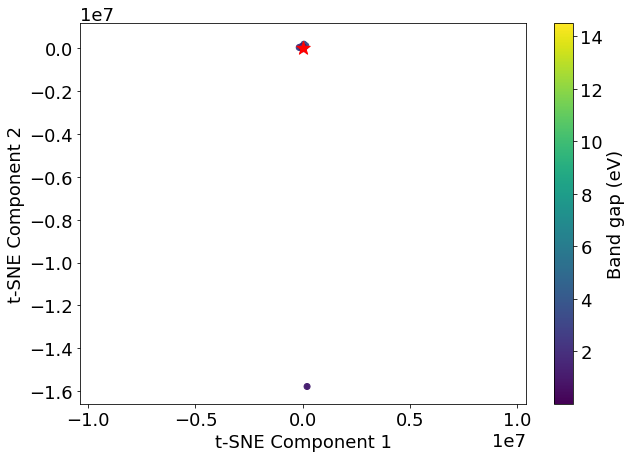

In [26]:
uid = "1160/3/0478C7E0B7C4F75C6081EC5184522704"
cr3se4_index = gap_projection.uids.index(uid)
print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
      .format(gap_projection.tags[cr3se4_index],
              gap_projection.responses[cr3se4_index],
              gap_projection.uids[cr3se4_index])
     )
print("Similar materials:")
for idx in find_most_similar_materials(cr3se4_index, coordinates_and_bg[:,0:2]):
    print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
          .format(gap_projection.tags[idx],
                  gap_projection.responses[idx],
                  gap_projection.uids[idx])
         )
plt.figure()
plt.scatter(gap_projection.xs, gap_projection.ys, c=gap_projection.responses)
plt.colorbar(label="Band gap (eV)")
plt.scatter(coordinates_and_bg[cr3se4_index, 0], coordinates_and_bg[cr3se4_index, 1],
            marker="*", c="r", s=200)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.axes().set_aspect('equal', 'datalim')
plt.show()

As we've seen here, t-SNE is a useful tool for understanding materials datasets and gaining new insights by visualizing and exploring a large, high-dimensional dataset in two dimensions. In this tutorial, we've seen how to examine outliers, find interesting clusters of similar materials, and find materials that are similar to a given material, which are only some of the cool things that you can do with t-SNE plots. The t-SNE analysis is available for all real-valued outputs specified in the Data Views creation process.